# Network Intrusion Detection using AI – Group Project Notebook

**Module:** CS6053NM – Artificial Intelligence and Machine Learning  
**Dataset:** KDD Cup 1999  
**Project Type:** Group Coursework – Network Intrusion Detection System (IDS)

---

## Group Information – **Group B**

| LMU ID | Name | Email |
|------|------|------|
| 25024547 | Angelo Perera | angeloperera221b@gmail.com |
| 25024544 | Ewan Rajap | ewanrajap07@gmail.com |
| 17029490 | Nisala Aloka Bandara | nisalatp@live.com |
| 25024548 | Tiran Pankaja | tiranpankaja@gmail.com |


---

## Notebook Scope

This notebook contains the **technical implementation** of an AI-based Intrusion Detection System, including:

- Data preparation and exploratory data analysis (EDA)  
- Feature preprocessing and transformation  
- Multiple machine learning model training  
- Performance comparison using IDS-relevant metrics  
- Visualization of predictions and classification performance  

**Note:**  
Model justification, ethical/legal discussion, and automated mitigation system design are documented **separately in the group report**, as per the coursework requirements.

*Generated on: 29 December 2025*


**Stage 0. Setup and Configuration**

In [ ]:
# =========================================================
# 0. ENVIRONMENT SETUP (Core Imports + Seeds + Paths)
# =========================================================

# Core
import os
import json
import time
import random
from datetime import datetime

# Data / Math
import numpy as np
import pandas as pd

# Visuals
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn (core)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Persistence
import joblib

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers  # if your NN class uses `layers.Dense(...)`

# Colab Drive
from google.colab import drive

# -------------------------
# Reproducibility
# -------------------------
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# -------------------------
# Paths
# -------------------------
google_drive_data_path = "/content/drive/MyDrive/NEXT/AI_ML/GProj/kddcup.csv"
base_dir = os.path.dirname(google_drive_data_path)
artifacts_root = os.path.join(base_dir, "artifacts")

# -------------------------
# Constants
# -------------------------
TARGET_COL = "label"
TEST_SIZE = 0.2

# -------------------------
# Mount Drive
# -------------------------
drive.mount('/content/drive')

print("Dataset:", google_drive_data_path)
print("Artifacts root:", artifacts_root)
print("Environment ready ✅")

# -------------------------
# KDD99 column names
# -------------------------
column_names = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
    'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
    'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'label'
]


Mounted at /content/drive
Dataset: /content/drive/MyDrive/NEXT/AI_ML/GProj/kddcup.csv
Artifacts root: /content/drive/MyDrive/NEXT/AI_ML/GProj/artifacts
Environment ready ✅


**Stage 01 : Data Loading**

In [ ]:
# Read CSV with explicit KDD Cup 1999 column names
df = pd.read_csv(google_drive_data_path, names=column_names)

print("Shape:", df.shape)
display(df.head())

print(df.info())
print("Duplicates:", df.duplicated().sum())

# Clean label values (remove trailing dot: normal. → normal)
df[TARGET_COL] = df[TARGET_COL].astype(str).str.rstrip(".")

display(df[TARGET_COL].value_counts())





Shape: (4898431, 38)


duration  protocol_type  service  flag  src_bytes  dst_bytes  \
0 tcp http SF       215          45076        0     0          0          0   
           SF       162           4528        0     0          0          0   
           SF       236           1228        0     0          0          0   
           SF       233           2032        0     0          0          0   
           SF       239            486        0     0          0          0   

               land  wrong_fragment  urgent  hot  ...  same_srv_rate  \
0 tcp http SF     0               1       0    0  ...              0   
           SF     0               1       0    0  ...              1   
           SF     0               1       0    0  ...              2   
           SF     0               1       0    0  ...              3   
           SF     0               1       0    0  ...              4   

               diff_srv_rate  srv_diff_host_rate  dst_host_count  \
0 tcp http SF            0.0                 0.0            0.00   
           SF            1.0                 0.0            1.00   
           SF            1.0                 0.0            0.50   
           SF            1.0                 0.0            0.33   
           SF            1.0                 0.0            0.25   

               dst_host_srv_count  dst_host_same_srv_rate  \
0 tcp http SF                 0.0                     0.0   
           SF                 0.0                     0.0   
           SF                 0.0                     0.0   
           SF                 0.0                     0.0   
           SF                 0.0                     0.0   

               dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0 tcp http SF                     0.0                          0.0   
           SF                     0.0                          0.0   
           SF                     0.0                          0.0   
           SF                     0.0                          0.0   
           SF                     0.0                          0.0   

               dst_host_srv_diff_host_rate    label  
0 tcp http SF                          0.0  normal.  
           SF                          0.0  normal.  
           SF                          0.0  normal.  
           SF                          0.0  normal.  
           SF                          0.0  normal.  

[5 rows x 38 columns]

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4898431 entries, (np.int64(0), 'tcp', 'http', 'SF') to (np.int64(0), 'tcp', 'http', 'SF')
Data columns (total 38 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   duration                     int64  
 1   protocol_type                int64  
 2   service                      int64  
 3   flag                         int64  
 4   src_bytes                    int64  
 5   dst_bytes                    int64  
 6   land                         int64  
 7   wrong_fragment               int64  
 8   urgent                       int64  
 9   hot                          int64  
 10  num_failed_logins            int64  
 11  logged_in                    int64  
 12  num_compromised              int64  
 13  root_shell                   int64  
 14  su_attempted                 int64  
 15  num_root                     int64  
 16  num_file_creations           int64  
 17  num_shells              

,count
label,
smurf,2807886
neptune,1072017
normal,972781
satan,15892
ipsweep,12481
portsweep,10413
nmap,2316
back,2203
warezclient,1020


**Stage 02 : Data Cleaning**

In [ ]:
# Remove duplicates
df = df.drop_duplicates()
print(f"After removing duplicates: {df.shape}")

# Check for missing values
missing_summary = df.isnull().sum()
missing_pct = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing_summary,
    'Missing_Percentage': missing_pct
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

if not missing_df.empty:
    print("\nMissing values detected:")
    display(missing_df)

    # Separate numeric and categorical columns
    num_cols_with_missing = df.select_dtypes(include=[np.number]).columns[df.select_dtypes(include=[np.number]).isnull().any()].tolist()
    cat_cols_with_missing = df.select_dtypes(exclude=[np.number]).columns[df.select_dtypes(exclude=[np.number]).isnull().any()].tolist()

    # Fill numeric columns with mean
    if num_cols_with_missing:
        for col in num_cols_with_missing:
            df[col].fillna(df[col].mean(), inplace=True)
        print(f"\nFilled {len(num_cols_with_missing)} numeric columns with mean values")

    # Fill categorical columns with mode
    if cat_cols_with_missing:
        for col in cat_cols_with_missing:
            df[col].fillna(df[col].mode()[0], inplace=True)
        print(f"Filled {len(cat_cols_with_missing)} categorical columns with mode values")
else:
    print("\nNo missing values detected")

# Split features and target
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

print(f"\nFinal dataset shape: {df.shape}")
print(f"Features: {X.shape}, Target: {y.shape}")


After removing duplicates: (1009765, 38)

No missing values detected

Final dataset shape: (1009765, 38)
Features: (1009765, 37), Target: (1009765,)


**Stage 03 : Exploratory Data Analysis**

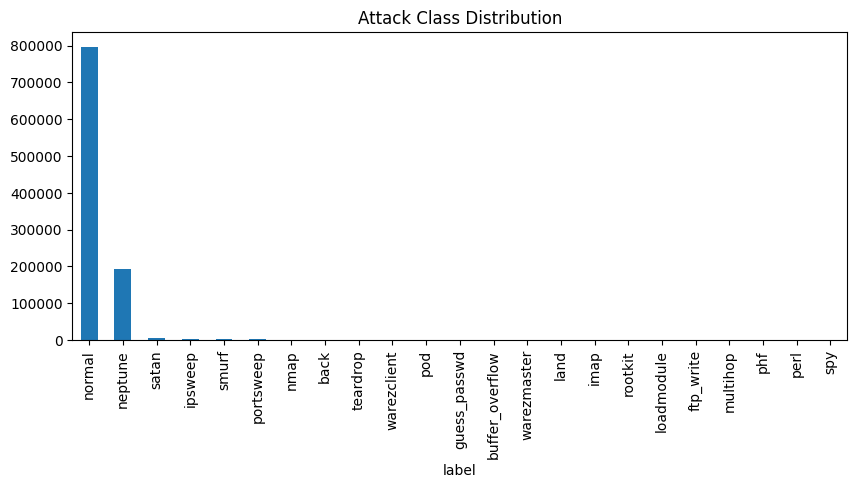

In [ ]:

plt.figure(figsize=(10,4))
y.value_counts().plot(kind='bar')
plt.title("Attack Class Distribution")
plt.show()


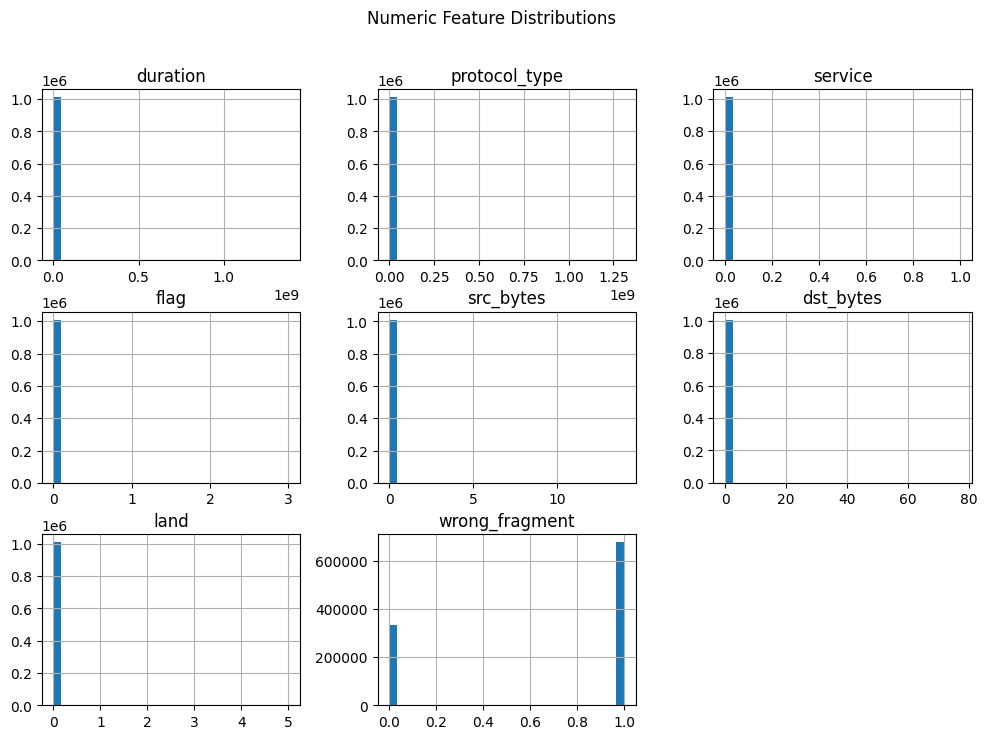

In [ ]:

num_cols = X.select_dtypes(include=[np.number]).columns[:8]
X[num_cols].hist(bins=30, figsize=(12,8))
plt.suptitle("Numeric Feature Distributions")
plt.show()


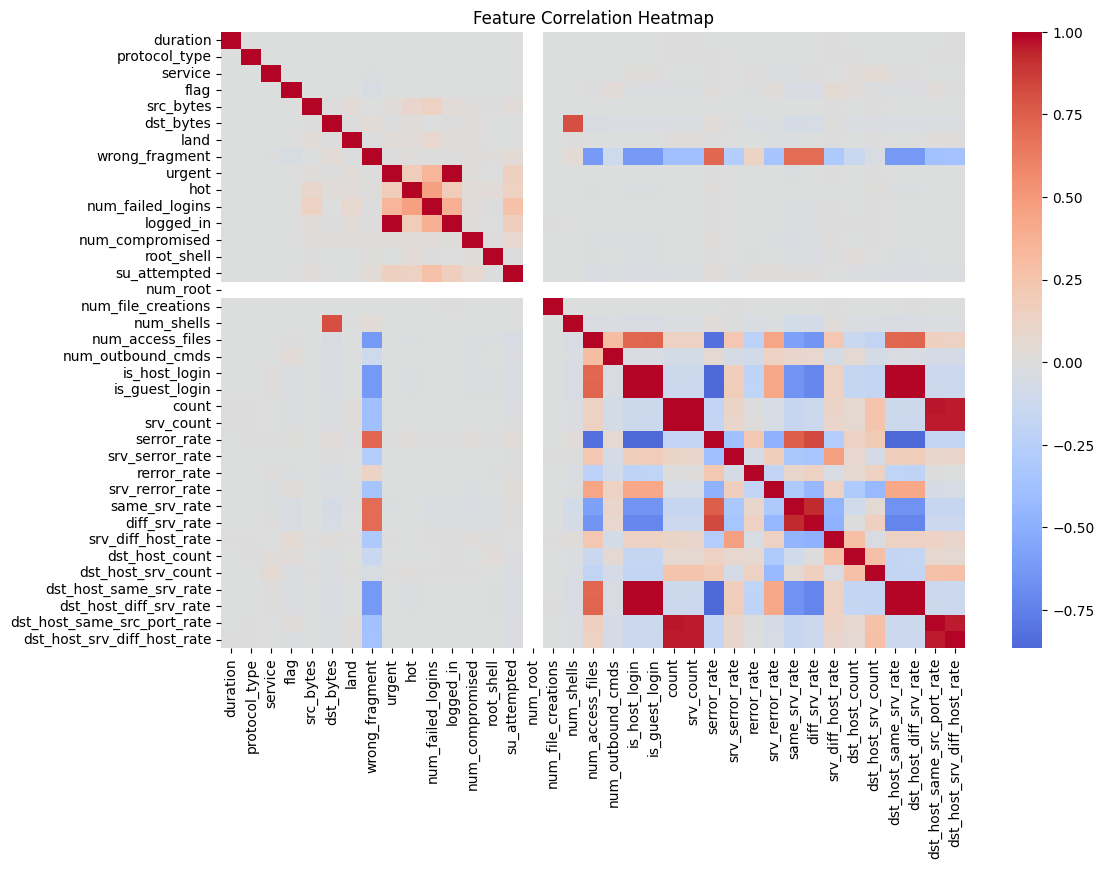

In [ ]:
plt.figure(figsize=(12,8))
corr = X.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap")
plt.show()


**Phase 04 : Preprocessing**

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = [c for c in X.columns if c not in num_features]

preprocess = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), num_features),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]), cat_features)
])

print(f"Numeric features: {len(num_features)}")
print(f"Categorical features: {len(cat_features)}")
print("Preprocessing pipeline ready")

Numeric features: 37
Categorical features: 0
Preprocessing pipeline ready


**Phase 05: Train / Test Split**

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape)

# Apply preprocessing pipeline
X_train_processed = preprocess.fit_transform(X_train)
X_test_processed = preprocess.transform(X_test)
print(f"After preprocessing - Train: {X_train_processed.shape}, Test: {X_test_processed.shape}")

# Encode labels for Neural Network
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
print(f"Encoded labels - Train: {y_train_encoded.shape}, Test: {y_test_encoded.shape}")
print(f"Number of classes: {len(label_encoder.classes_)}")


Train: (807812, 37) Test: (201953, 37)
After preprocessing - Train: (807812, 37), Test: (201953, 37)
Encoded labels - Train: (807812,), Test: (201953,)
Number of classes: 23


**Phase 06 : Model Training**

06.0 : Preparation

In [ ]:
# Base class for all models
class BaseIDS:
    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)

        metrics = {
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred, average='macro', zero_division=0),
            "Recall": recall_score(y_test, y_pred, average='macro', zero_division=0),
            "F1 Score": f1_score(y_test, y_pred, average='macro', zero_division=0)
        }
        return metrics, y_pred

# Define Logistic Regression class
class LogisticRegressionIDS(BaseIDS):
    def __init__(self, max_iter=2000):
        self.model = LogisticRegression(
            max_iter=max_iter,
            random_state=42,
            class_weight='balanced',
            n_jobs=-1
        )

    def train(self, X_train, y_train):
        print("Training Logistic Regression...")
        self.model.fit(X_train, y_train)
        print("Training complete!")

    def predict(self, X_test):
        return self.model.predict(X_test)

# Define Random Forest class
class RandomForestIDS(BaseIDS):
    def __init__(self, n_estimators=300, max_depth=20):
        self.model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            random_state=42,
            n_jobs=-1,
            class_weight='balanced'
        )

    def train(self, X_train, y_train):
        print("Training Random Forest...")
        self.model.fit(X_train, y_train)
        print("Training complete!")

    def predict(self, X_test):
        return self.model.predict(X_test)

# Define Neural Network class
class NeuralNetworkIDS(BaseIDS):
    def __init__(self, input_dim, num_classes, learning_rate=0.001):
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.model = self._build_model(learning_rate)

    def _build_model(self, lr):
        model = keras.Sequential([
            layers.Input(shape=(self.input_dim,)),
            layers.Dense(64, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.Dense(32, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.Dense(16, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(self.num_classes, activation='softmax')
        ])
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=lr),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

    def train(self, X_train, y_train, epochs=20, batch_size=32):
        print("Training Neural Network...")
        self.history = self.model.fit(
            X_train, y_train,
            validation_split=0.2,
            epochs=epochs,
            batch_size=batch_size,
            verbose=1
        )
        print("Training complete!")

    def predict(self, X_test):
        y_pred_proba = self.model.predict(X_test, verbose=0)
        return np.argmax(y_pred_proba, axis=1)


# Initialize and train models sequentially
trained = {}
results = []

06.1 Train Logistic Regression

In [ ]:
# Logistic Regression
lr_model = LogisticRegressionIDS(max_iter=2000)
lr_model.train(X_train_processed, y_train)
trained["Logistic Regression"] = lr_model
metrics, _ = lr_model.evaluate(X_test_processed, y_test)
results.append({"Model": "Logistic Regression", **metrics})

Training Logistic Regression...
Training complete!


06.2 Train Random Forest

In [ ]:
# Random Forest
rf_model = RandomForestIDS(n_estimators=300, max_depth=20)
rf_model.train(X_train_processed, y_train)
trained["Random Forest"] = rf_model
metrics, _ = rf_model.evaluate(X_test_processed, y_test)
results.append({"Model": "Random Forest", **metrics})

Training Random Forest...
Training complete!


06.3 Train Neural Network

In [ ]:
# Neural Network
nn_model = NeuralNetworkIDS(
    input_dim=X_train_processed.shape[1],
    num_classes=len(np.unique(y_train_encoded)),
    learning_rate=0.001
)
nn_model.train(X_train_processed, y_train_encoded, epochs=20, batch_size=32)
trained["Neural Network"] = nn_model
metrics, _ = nn_model.evaluate(X_test_processed, y_test_encoded)
results.append({"Model": "Neural Network", **metrics})

Training Neural Network...
Epoch 1/20
20196/20196 ━━━━━━━━━━━━━━━━━━━━ 94s 4ms/step - accuracy: 0.9742 - loss: 0.1200 - val_accuracy: 0.9953 - val_loss: 0.0254
Epoch 2/20
20196/20196 ━━━━━━━━━━━━━━━━━━━━ 84s 4ms/step - accuracy: 0.9924 - loss: 0.0292 - val_accuracy: 0.9965 - val_loss: 0.0389
Epoch 3/20
20196/20196 ━━━━━━━━━━━━━━━━━━━━ 80s 4ms/step - accuracy: 0.9937 - loss: 0.0247 - val_accuracy: 0.9965 - val_loss: 0.0239
Epoch 4/20
20196/20196 ━━━━━━━━━━━━━━━━━━━━ 78s 4ms/step - accuracy: 0.9945 - loss: 0.0218 - val_accuracy: 0.9971 - val_loss: 0.0288
Epoch 5/20
20196/20196 ━━━━━━━━━━━━━━━━━━━━ 77s 4ms/step - accuracy: 0.9945 - loss: 0.0209 - val_accuracy: 0.9972 - val_loss: 0.0232
Epoch 6/20
20196/20196 ━━━━━━━━━━━━━━━━━━━━ 78s 4ms/step - accuracy: 0.9949 - loss: 0.0201 - val_accuracy: 0.9971 - val_loss: 0.0237
Epoch 7/20
20196/20196 ━━━━━━━━━━━━━━━━━━━━ 79s 4ms/step - accuracy: 0.9951 - loss: 0.0202 - val_accuracy: 0.9970 - val_loss: 0.0276
Epoch 8/20
20196/20196 ━━━━━━━━━━━━━━━━━━━

06.4 : Save Models

In [ ]:
import os
import json
import joblib
from datetime import datetime

def export_all_artifacts(
    artifacts_root,
    trained,
    preprocess,
    label_encoder,
    results_df=None,
    run_tag="groupB_kdd99"
):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_root = os.path.join(artifacts_root, f"{run_tag}_{timestamp}")

    paths = {
        "common": os.path.join(run_root, "common"),
        "lr": os.path.join(run_root, "logistic_regression"),
        "rf": os.path.join(run_root, "random_forest"),
        "nn": os.path.join(run_root, "neural_network")
    }
    for p in paths.values():
        os.makedirs(p, exist_ok=True)

    # common
    joblib.dump(preprocess, os.path.join(paths["common"], "feature_preprocessor.pkl"))
    joblib.dump(label_encoder, os.path.join(paths["common"], "label_encoder.pkl"))

    metadata = {
        "saved_at": datetime.now().isoformat(timespec="seconds"),
        "run_tag": run_tag,
        "models_saved": list(trained.keys()),
        "formats": {
            "logistic_regression": "joblib (.pkl)",
            "random_forest": "joblib (.pkl)",
            "neural_network": "Keras v3 native (.keras)"
        }
    }
    with open(os.path.join(paths["common"], "metadata.json"), "w") as f:
        json.dump(metadata, f, indent=2)

    # LR
    if "Logistic Regression" in trained:
        joblib.dump(trained["Logistic Regression"].model,
                   os.path.join(paths["lr"], "logistic_regression_ids.pkl"))

    # RF
    if "Random Forest" in trained:
        joblib.dump(trained["Random Forest"].model,
                   os.path.join(paths["rf"], "random_forest_ids.pkl"))

    # NN (Keras 3 requires file extension)
    if "Neural Network" in trained:
        nn_path = os.path.join(paths["nn"], "neural_network_ids.keras")
        trained["Neural Network"].model.save(nn_path)

    # results
    if results_df is not None:
        results_df.to_csv(os.path.join(run_root, "results_summary.csv"), index=False)

    print("✅ All artifacts saved successfully")
    print("📁 Location:", run_root)
    return run_root


# EXECUTE EXPORT  (IMPORTANT: your preprocessor variable is `preprocess`)
run_folder = export_all_artifacts(
    artifacts_root=artifacts_root,
    trained=trained,
    preprocess=preprocess,
    label_encoder=label_encoder,
    results_df=results_df,
    run_tag="groupB_kdd99"
)


✅ All artifacts saved successfully
📁 Location: /content/drive/MyDrive/NEXT/AI_ML/GProj/artifacts/groupB_kdd99_20251230_053256


06.5 : Visualize Results

In [ ]:
# Display results
results_df = pd.DataFrame(results).rename(columns={
    "Accuracy": "Accuracy",
    "Precision": "Precision_macro",
    "Recall": "Recall_macro",
    "F1 Score": "F1_macro"
})
display(results_df)


import time

timings = []

for name, model in trained.items():
    start = time.time()
    model.predict(X_test_processed)
    elapsed = time.time() - start
    timings.append({"Model": name, "Inference_Time_sec": elapsed})

timing_df = pd.DataFrame(timings)
display(timing_df)


from sklearn.metrics import classification_report

for name, model in trained.items():
    print(f"\n{name}")
    y_pred = model.predict(X_test_processed)
    if name == "Neural Network":
        y_pred = label_encoder.inverse_transform(y_pred)
    print(classification_report(y_test, y_pred, zero_division=0))


,Model,Accuracy,Precision_macro,Recall_macro,F1_macro
0,Logistic Regression,0.936173,0.414283,0.890324,0.475689
1,Logistic Regression,0.936173,0.414283,0.890324,0.475689
2,Random Forest,0.999530,0.809938,0.745888,0.768646
3,Neural Network,0.997816,0.470893,0.444267,0.453986


,Model,Inference_Time_sec
0,Logistic Regression,0.094941
1,Random Forest,17.983802
2,Neural Network,15.260495



Logistic Regression
                 precision    recall  f1-score   support

           back       0.61      0.99      0.75       193
buffer_overflow       0.02      1.00      0.05         6
      ftp_write       0.02      0.50      0.04         2
   guess_passwd       0.92      1.00      0.96        11
           imap       0.02      1.00      0.03         2
        ipsweep       0.40      0.96      0.56       740
           land       1.00      1.00      1.00         4
     loadmodule       0.01      0.50      0.02         2
       multihop       0.02      1.00      0.04         1
        neptune       1.00      1.00      1.00     38871
           nmap       0.07      0.95      0.14       302
         normal       1.00      0.92      0.96    159338
           perl       0.50      1.00      0.67         1
            phf       0.50      1.00      0.67         1
            pod       0.98      1.00      0.99        41
      portsweep       0.62      0.99      0.76       477
        r

**Stage 07 : Confusion matrix**

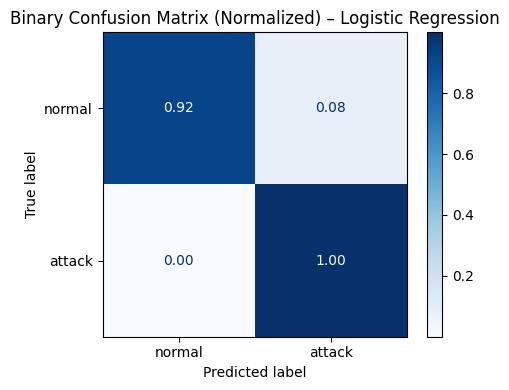

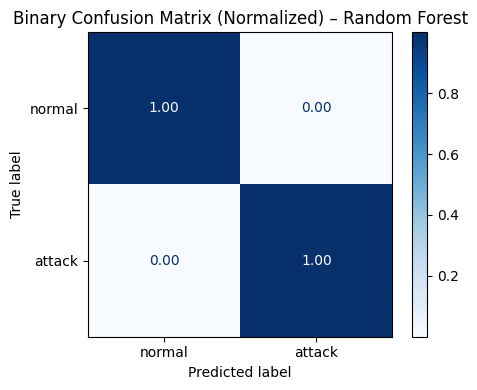

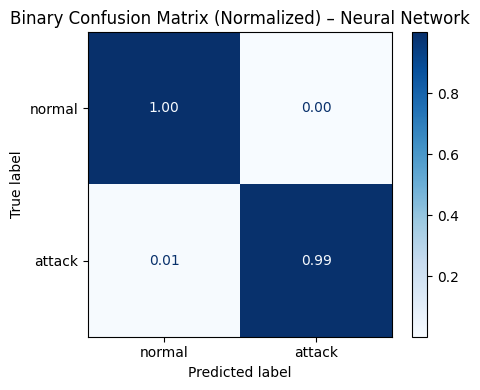

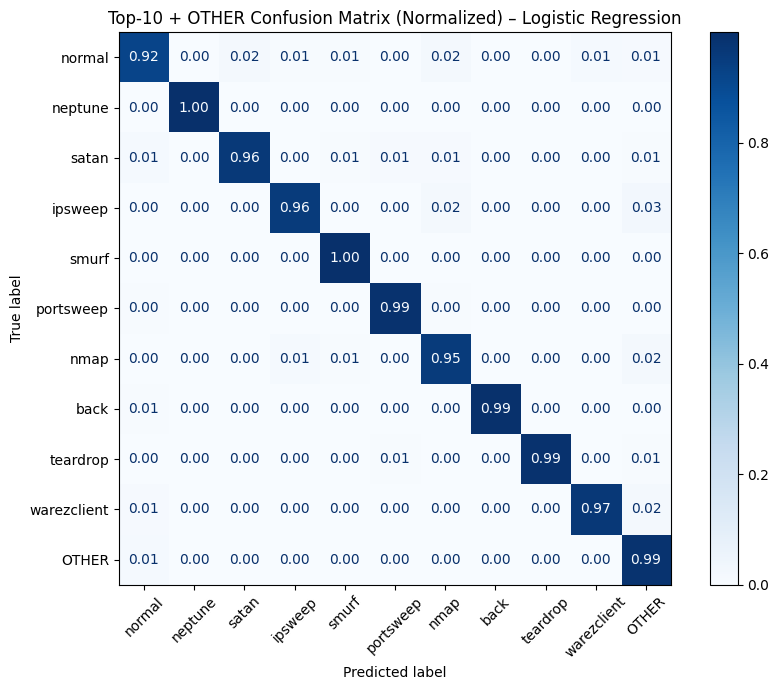

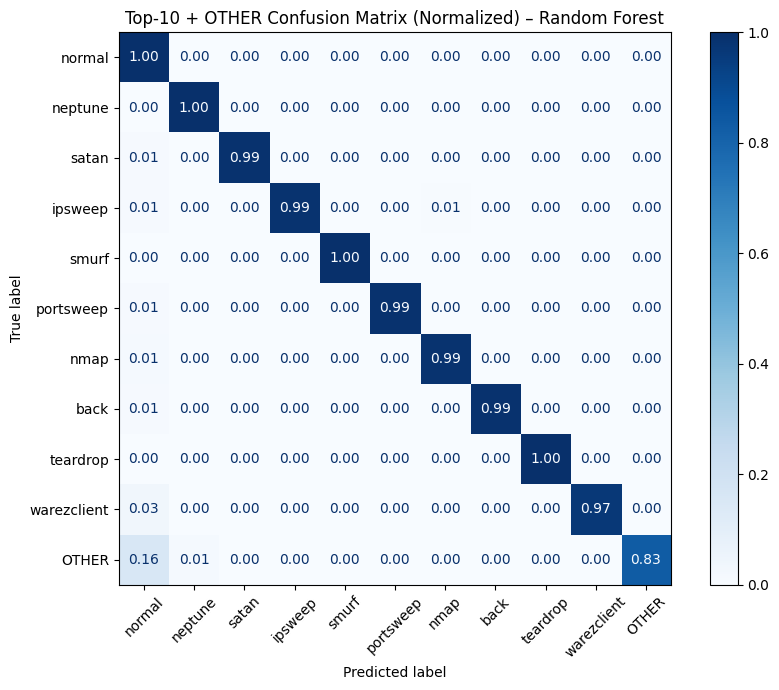

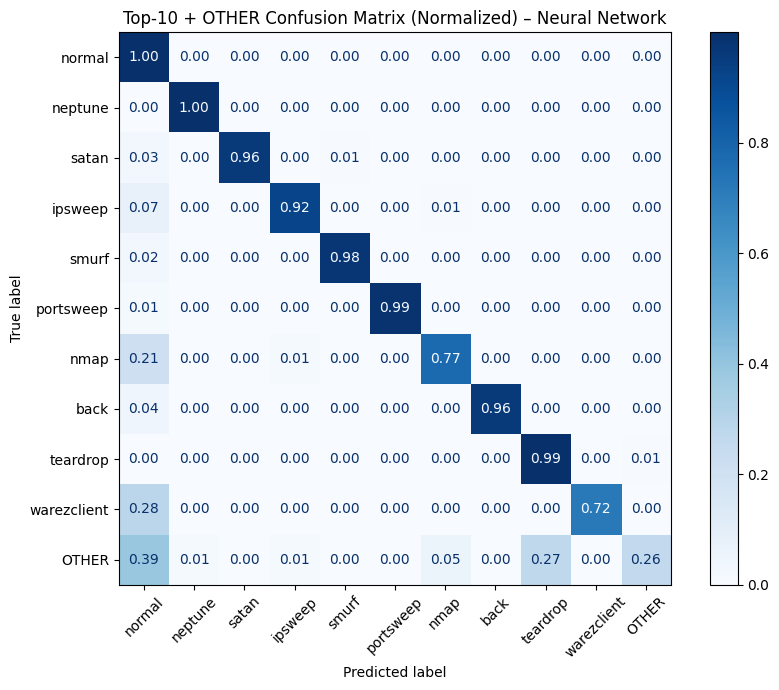

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ---------- helpers ----------
def get_predictions(model_name, model, X_test_processed, label_encoder):
    """Return string labels for all models."""
    if model_name == "Neural Network":
        y_pred_encoded = model.predict(X_test_processed)
        return label_encoder.inverse_transform(y_pred_encoded)
    return model.predict(X_test_processed)

def to_binary_labels(arr):
    """Map multiclass labels -> binary IDS view."""
    arr = np.array(arr)
    return np.where(arr == "normal", "normal", "attack")

def collapse_to_topN(y, top_classes):
    """Keep top classes; everything else -> OTHER."""
    y = np.array(y)
    return np.array([v if v in top_classes else "OTHER" for v in y])

# ---------- settings ----------
TOP_N = 10

# Determine top classes from the TEST set (most meaningful for evaluation visuals)
top_classes = y_test.value_counts().head(TOP_N).index.tolist()
labels_topN = top_classes + ["OTHER"]

# ---------- PLOT 1: Binary (normal vs attack) ----------
for model_name, model in trained.items():
    y_pred = get_predictions(model_name, model, X_test_processed, label_encoder)

    y_true_bin = to_binary_labels(y_test.values)
    y_pred_bin = to_binary_labels(y_pred)

    labels_bin = ["normal", "attack"]
    cm_bin = confusion_matrix(y_true_bin, y_pred_bin, labels=labels_bin, normalize="true")

    fig, ax = plt.subplots(figsize=(5, 4))
    ConfusionMatrixDisplay(cm_bin, display_labels=labels_bin).plot(
        ax=ax, cmap="Blues", values_format=".2f", colorbar=True
    )
    ax.set_title(f"Binary Confusion Matrix (Normalized) – {model_name}")
    plt.tight_layout()
    plt.show()

# ---------- PLOT 2: Top-N + OTHER (Normalized) ----------
for model_name, model in trained.items():
    y_pred = get_predictions(model_name, model, X_test_processed, label_encoder)

    y_true_top = collapse_to_topN(y_test.values, top_classes)
    y_pred_top = collapse_to_topN(y_pred, top_classes)

    cm_top = confusion_matrix(y_true_top, y_pred_top, labels=labels_topN, normalize="true")

    fig, ax = plt.subplots(figsize=(9, 7))
    ConfusionMatrixDisplay(cm_top, display_labels=labels_topN).plot(
        ax=ax, cmap="Blues", values_format=".2f", colorbar=True, xticks_rotation=45
    )
    ax.set_title(f"Top-{TOP_N} + OTHER Confusion Matrix (Normalized) – {model_name}")
    plt.tight_layout()
    plt.show()


**Stage 08 : ROC and Precision-Recall Curves**

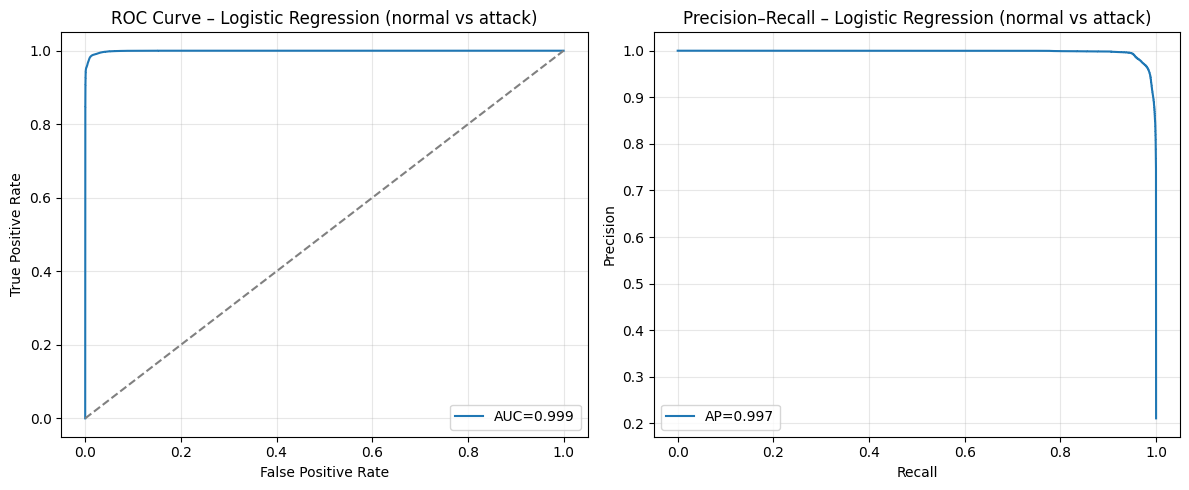

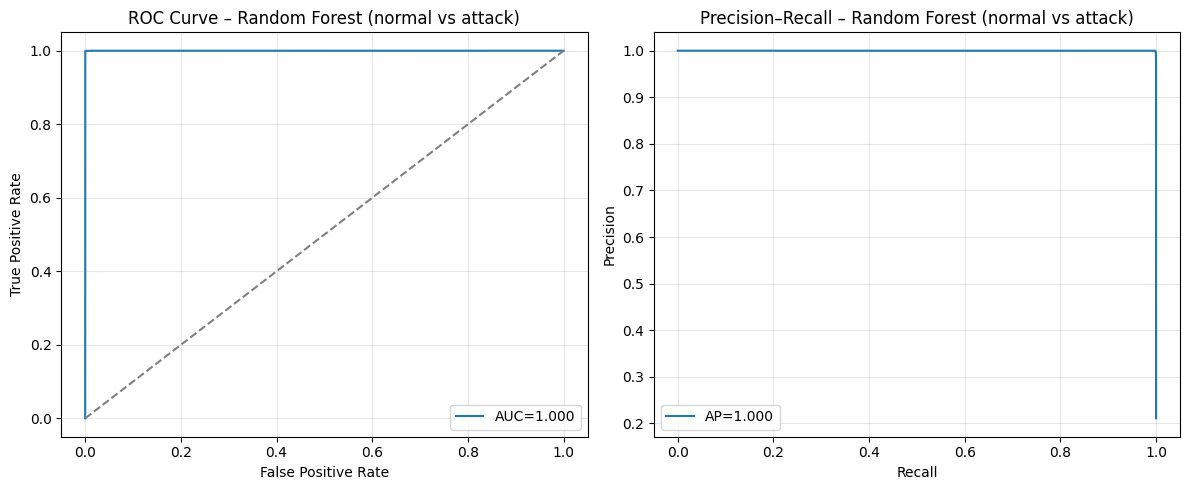

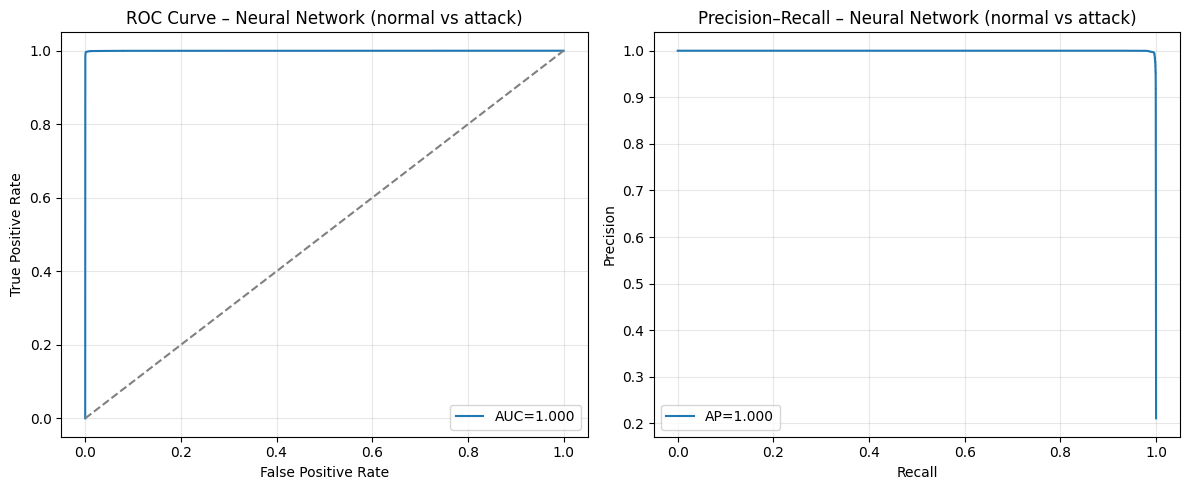

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score


# Binary ground truth: 0=normal, 1=attack
y_binary = (y_test.values != "normal").astype(int)

def plot_roc_pr(model_name, y_scores):
    fpr, tpr, _ = roc_curve(y_binary, y_scores)
    roc_auc = auc(fpr, tpr)

    precision, recall, _ = precision_recall_curve(y_binary, y_scores)
    ap = average_precision_score(y_binary, y_scores)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve – {model_name} (normal vs attack)")
    plt.legend()
    plt.grid(alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f"AP={ap:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision–Recall – {model_name} (normal vs attack)")
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

# ----- LR -----
lr = trained["Logistic Regression"]
probs = lr.model.predict_proba(X_test_processed)
normal_idx = int(np.where(lr.model.classes_ == "normal")[0][0])
lr_scores = 1.0 - probs[:, normal_idx]
plot_roc_pr("Logistic Regression", lr_scores)

# ----- RF -----
rf = trained["Random Forest"]
probs = rf.model.predict_proba(X_test_processed)
normal_idx = int(np.where(rf.model.classes_ == "normal")[0][0])
rf_scores = 1.0 - probs[:, normal_idx]
plot_roc_pr("Random Forest", rf_scores)

# ----- NN -----
nn = trained["Neural Network"]
probs = nn.model.predict(X_test_processed, verbose=0)  # (n, 23)
normal_idx = int(np.where(label_encoder.classes_ == "normal")[0][0])
nn_scores = 1.0 - probs[:, normal_idx]
plot_roc_pr("Neural Network", nn_scores)
